## Setup

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors, cm
import scprep
import geopandas as gpd
import os

## Data Loading

In [2]:
map0 = gpd.read_file(os.path.join("..", "..", "data", "korea_shapefile", 'KOR_adm0.shp'))

In [3]:
df = pd.read_csv('../../data/coronavirusdataset/PatientRoute.csv')
df

,patient_id,global_num,date,province,city,latitude,longitude
0,1400000001,1,2020-01-19,Incheon,Jung-gu,37.460459,126.440680
1,1400000001,1,2020-01-20,Incheon,Seo-gu,37.478832,126.668558
2,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884
3,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627
4,2000000001,3,2020-01-20,Incheon,Jung-gu,37.460459,126.440680
...,...,...,...,...,...,...,...
170,1200000031,31,2020-02-09,Daegu,Nam-gu,35.839820,128.566600
171,1200000031,31,2020-02-15,Daegu,Dong-gu,35.882410,128.662100
172,1200000031,31,2020-02-16,Daegu,Nam-gu,35.839820,128.566600
173,1200000031,31,2020-02-17,Daegu,Suseong-gu,35.844730,128.612300


## Mapping

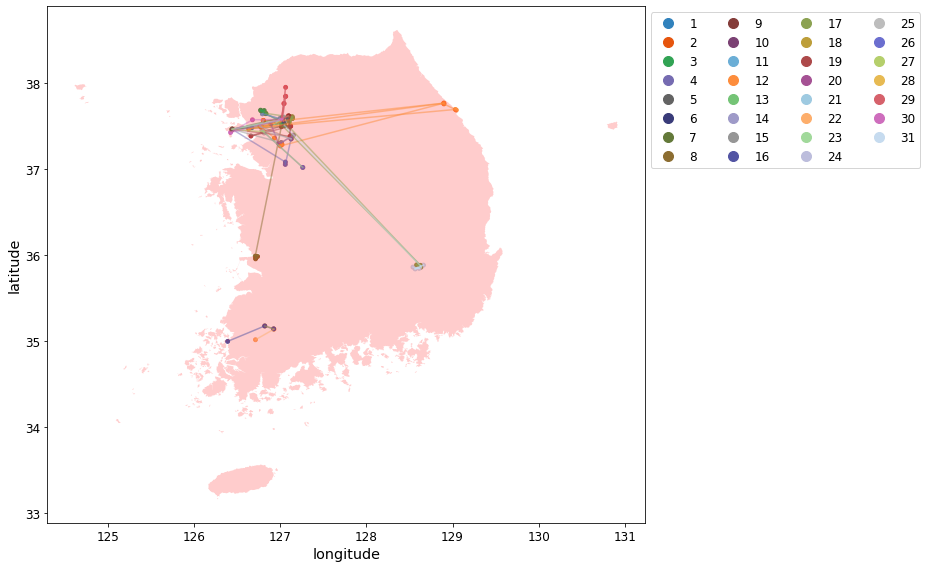

In [4]:
colors = scprep.plot.colors.tab(len(np.unique(df['global_num']))).colors
cmap = {patient:colors[i] for i, patient in enumerate(np.unique(df['global_num']))}
ax = scprep.plot.scatter(x = df['longitude'], y=df['latitude'], c=df['global_num'], cmap=cmap,
                         legend_anchor=(1,1), figsize=(16,8), discrete=True)
map0.plot(ax=ax, color='red', alpha=0.2)
for patient in np.unique(df['global_num']):
    plot_df = df.loc[df['global_num']==patient].sort_values('date')
    for i in range(plot_df.shape[0]-1):
        ax.plot(plot_df.iloc[[i,i+1]]['longitude'], plot_df.iloc[[i,i+1]]['latitude'], color=cmap[patient], alpha=0.5)

## Risk estimation

In [6]:
from scipy.spatial.distance import pdist, squareform
def dist(i, j):
    df_i = df.loc[df['global_num'] == i]
    df_j = df.loc[df['global_num'] == j]
    min_dist = np.float64('inf')
    for _, x in df_i.iterrows():
        for _, y in df_j.iterrows():
            d = np.sqrt(np.sum((x[['latitude', 'longitude']] - y[['latitude', 'longitude']])**2))
            if d < min_dist:
                min_dist = d
    return min_dist
pdist = np.array([[dist(i, j) for i in np.unique(df['global_num'])] for j in np.unique(df['global_num'])])

In [7]:
#let's say N of the G people were infected
#then go to the locations of these N people
#lets say each infected person i had contact with Ci people
#then each infected person increases the risk in their region by k*Ci
#so we can make a heatmap of the k*Ci! 

In [8]:
#ok let's try this. Let's say people 1, 6, 11, 16 and 21 are infected 
infected_num = [1, 6, 11, 16, 21]

In [9]:
mask =  np.tri(pdist.shape[0], k=-1)

In [10]:
sparse_pdist = np.ma.array(pdist, mask=mask)

In [11]:
contact_dist_max = 0.02
close_pairs = np.argwhere(sparse_pdist < contact_dist_max)

In [12]:
degrees_of_infection = np.zeros(len(pdist))

In [13]:
degrees_of_infection[infected_num] = 1

In [14]:
degrees_of_infection

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
p_infect = .1
for pair in close_pairs:
    if pair[0] in infected_num:
        i = pair[1]
        degrees_of_infection[i] += p_infect

In [18]:
degrees_of_infection[degrees_of_infection > 1] = 1
degrees_of_infection
df['Probability_infected'] = None

In [20]:
for i in df.index:
    person = df['global_num'][i]
    df.loc[i, 'Probability_infected'] = degrees_of_infection[person - 1]

In [21]:
df

,patient_id,global_num,date,province,city,latitude,longitude,Probability_infected
0,1400000001,1,2020-01-19,Incheon,Jung-gu,37.460459,126.440680,0
1,1400000001,1,2020-01-20,Incheon,Seo-gu,37.478832,126.668558,0
2,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884,1
3,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627,1
4,2000000001,3,2020-01-20,Incheon,Jung-gu,37.460459,126.440680,0
...,...,...,...,...,...,...,...,...
170,1200000031,31,2020-02-09,Daegu,Nam-gu,35.839820,128.566600,0.1
171,1200000031,31,2020-02-15,Daegu,Dong-gu,35.882410,128.662100,0.1
172,1200000031,31,2020-02-16,Daegu,Nam-gu,35.839820,128.566600,0.1
173,1200000031,31,2020-02-17,Daegu,Suseong-gu,35.844730,128.612300,0.1


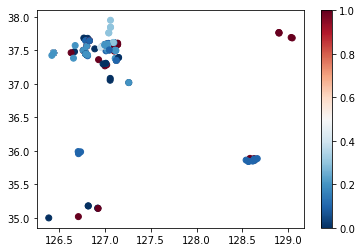

In [22]:
#now we use the location + infection probability to make a heatmap
plt.scatter(df['longitude'], df['latitude'], c=df['Probability_infected'], cmap=cm.RdBu_r)
plt.colorbar()
#right but I want to interpolate/smooth this a bit

In [23]:
# x = np.linspace(df['longitude'].min(), df['longitude'].max(), 30)
x = np.linspace(126, 129.2, 100)
y = np.linspace(34,38,100)
# y = np.linspace(df['latitude'].min(), df['latitude'].max(), 30)
X, Y = np.meshgrid(x, y)
heat = np.zeros_like(X)

for xi,yi, p in zip(df['longitude'], df['latitude'], df['Probability_infected']):
    xbin = np.argmin(abs(xi - x))
    ybin = np.argmin(abs(yi - y))
    heat[xbin-1, ybin-1] += p #the -1 is because of how bins work

(34.0, 38.0)

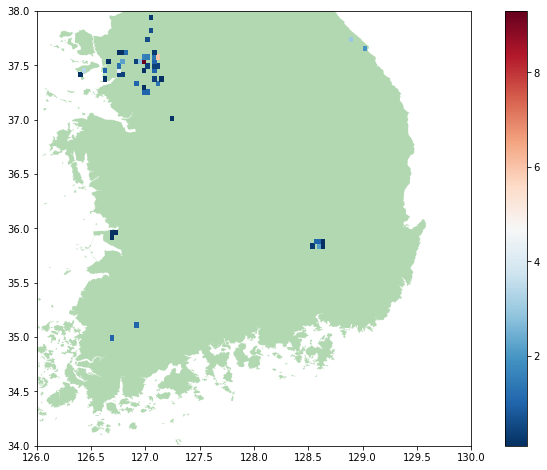

In [24]:
heat[heat < .1] = np.nan
fig, ax = plt.subplots(figsize=(12,8))
map0.plot(ax=ax, color='green', alpha=0.3)
a1 = ax.pcolormesh(X, Y, heat.T, cmap=cm.RdBu_r)
plt.colorbar(a1, ax=ax)
plt.xlim(126,130)
plt.ylim(34, 38)

In [ ]:
#right, in principle we can fine grain this as much as we want.. but make sure you're not going finer than data sampling